# Gender classification task. Constructing and training neural network

This notebook contains code of CNN model creation and training.

CNN model based on the LeNet-5 architecture and contains two convolutional layers, followed by max pooling layers and three fully-connected layers.

All images were resized to the shape 64x64, converting to tensors and normalized.

Train sample was divided into training and validation sets in ratio 95:5.

In [1]:
import torch
import numpy as np

# Uploading data

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
train_val_separator = 0.95

In [5]:
# Create custom transformation as a composition of three transformations. 
# It will be applied to all images in train and test datasets
img_processing_transform = transforms.Compose(
    [transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
'''
Custom class which extends torchvision.datasets.ImageFolder to get not only images and labels,
but also images' paths
'''
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    # override the original __getitem__ method
    def __getitem__(self, index):
        # standart return of the ImageFolder
        standart_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        
        # the image file path
        img_path = self.imgs[index][0]
        
        # make a new tuple that includes original and the path
        extended_tuple = (standart_tuple + (img_path,))
        return extended_tuple

In [7]:
# Create dataset with all train data using custom ImageFolderWithPaths class
dataset = ImageFolderWithPaths(root="./internship_data/", transform=img_processing_transform)

# Split data into train and validation sets
train_size = int(np.floor(len(dataset) * train_val_separator))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [8]:
# Upload train and validation data using DataLoader
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, drop_last=False, num_workers=4)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, drop_last=False, num_workers=4)

In [9]:
# Define classes names
classes = ('female', 'male')

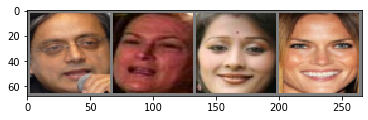

 male female female female


In [11]:
# Show some images from the train set
import matplotlib.pyplot as plt

# Functions to show an image
def img_show(img):
    img = img / 2 + 0.5 #unnormalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Select some random training images for showing
dataiter = iter(train_data_loader)
images, labels, paths = dataiter.next()

img_show(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[i]] for i in range(4)))

# Constructing CNN

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layer with 3 input chanels and 6 filters each of the size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Convolutional layer with 6 input chanels and 16 filters each of the size 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Pooling layer (max pool) with the size of 2x2
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully-connected layer with the number of input neurons: # chanels * height * width
        # Height and width were calculated for the input size of 64x64
        self.fc1 = nn.Linear(16 * 13 * 13, 120) 
        # Fully-connected layer with the number of input neurons 120 and number of output neurons 84
        self.fc2 = nn.Linear(120, 84)
        # Fully-connected layer with the number of input neurons 84 and number of output neurons 84
        self.fc3 = nn.Linear(84, 84)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Apply ReLU non-linearity and pooling to the CONV1 layer
        x = self.pool(F.relu(self.conv2(x))) # Apply ReLU non-linearity and pooling to the CONV2 layer
        
        x = x.view(-1, 16 * 13 * 13) # Reshape x to the vector (for FC layer)
        x = F.relu(self.fc1(x)) # Apply ReLU non-linearity to the FC1 layer
        x = F.relu(self.fc2(x)) # Apply ReLU non-linearity to the FC2 layer
        x = self.fc3(x) # Apply FC3 layer
        return x

net = Net()

In [13]:
import torch.optim as optim

# Initialize loss function and optimization algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Procedure of training

# Number of epoches was found empirically (untill the loss function value stabilized)
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # Get the input data and labels
        inputs, labels, _ = data

        # Set the parameter gradients to zero
        optimizer.zero_grad()

        # Forward step, backward step and optimization
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Show statistics of the training process
        running_loss += loss.item()
        if i % 4000 == 2000:    # print every 4000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished')

In [ ]:
# Save the trained model 
PATH = './gender_classification_net.pth'
torch.save(net.state_dict(), PATH)

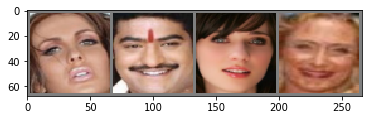

female  male female female


In [27]:
# Show some images from the test set
dataiter = iter(val_data_loader)
images, labels, _ = dataiter.next()

img_show(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
# Upload the trained model
net = Net()
PATH = './gender_classification_net.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
# Predict labels for shown images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  female  male female female


In [29]:
# Calculate the accuracy on the validation set
correct = 0
total = 0
with torch.no_grad():
    for data in val_data_loader:
        images, labels, paths = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 5001 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 5001 test images: 95 %
